In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.wkt import loads
from shapely.geometry import Point
import os

import warnings
warnings.filterwarnings('ignore')

### Script Objectives:

This script filters our two main camera datasets (Amnesty Internation and Hikvision) via spatial joins on Brooklyn's shapefile. This will return a subset of the original camera datasets that we are interested in for our surviellance metric to be created for the neighborhoods across Brooklyn.

#### Input Files:

 **Cameras**

 * Amnesty International Cameras in Brookyln: `../Data/amnesty_international_cameras_brooklyn.csv`

 * Hikvision Cameras in Brooklyn: `../Data/hikvision_camera_brooklyn.csv`
 
  * Aggregated Camera Counts for NYC Census Tracts: `../Data/NYC_tracts_camera_aggregates.csv`


 **Shapefiles**

 * Brooklyn Census Blocks: `'../Data/BrooklynBlocks/BrooklynBlocks.shp'`

 * Brooklyn Census Tracts: `'../Data/BrooklynTracts/BrooklynTracts.shp'`

 * Brooklyn Census Block Groups: `../Data/BrooklynBlockGroups/BrooklynBlockGroups.shp`
 

#### Output Files:

In [19]:
#read camera datasets
am_int = gpd.read_file('../Data/amnesty/amnesty_international_cameras_brooklyn.shp', index_col = 0)
hik = gpd.read_file('../Data/hikvision/hikvision_camera_brooklyn.shp', index_col = 0)

In [20]:
am_int.head()

,PanoramaId,n_cameras_,attached_s,attached_b,attached_u,type_dome_,type_bulle,type_unkno,n_camera_1,attached_1,...,type_dom_1,type_bul_1,type_unk_1,Lat,Long,geometry_p,BoroName,URL,ImageDate,geometry
0,--kQB7vdISN5ZhBDo82BHg,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.706633,-73.935702,POINT (-73.93570246701009 40.70663303266096),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.93570 40.70663)
1,-0Kgxt4Lfda78gY2WuEMqA,0,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,Unanimous,2 vs 1,40.639826,-73.897770,POINT (-73.89777023441276 40.63982610941098),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.89777 40.63983)
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95673 40.69289)
3,-0Y6fGJQcnKZ-crSKaVIfQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.662758,-73.885122,POINT (-73.88512163867377 40.66275783316144),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.88512 40.66276)
4,-0yXEvW841dBjrs54VZKIA,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.655396,-74.003186,POINT (-74.00318577678686 40.65539642907692),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-06,POINT (-74.00319 40.65540)


In [60]:
am_int.columns

Index(['PanoramaId', 'n_cameras_', 'attached_s', 'attached_b', 'attached_u',
       'type_dome_', 'type_bulle', 'type_unkno', 'n_camera_1', 'attached_1',
       'attached_2', 'attached_3', 'type_dom_1', 'type_bul_1', 'type_unk_1',
       'Lat', 'Long', 'geometry_p', 'BoroName', 'URL', 'ImageDate',
       'geometry'],
      dtype='object')

In [61]:
print(len(am_int))
am_int = am_int[am_int['n_cameras_']> 0]
print(len(am_int))

10377
4662


<AxesSubplot:>

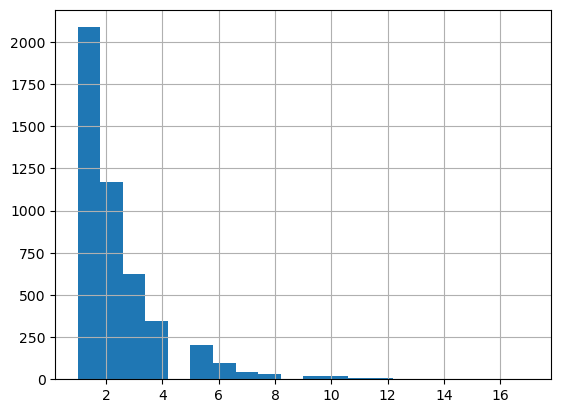

In [75]:
am_int['n_cameras_'].hist(bins = 20)

In [81]:
Coverage = []

for i in range(0,len(am_int)):
    if am_int.iloc[i]['n_cameras_'] == 1:
        Coverage.append('Single Camera')
    else:
        Coverage.append('Multiple Cameras')
am_int['Coverage'] = Coverage
am_int.head()

,PanoramaId,n_cameras_,attached_s,attached_b,attached_u,type_dome_,type_bulle,type_unkno,n_camera_1,attached_1,...,type_unk_1,Lat,Long,geometry_p,BoroName,URL,ImageDate,geometry,buffer_distance,Coverage
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (303657.098 58435.534),120,Multiple Cameras
7,-3_J1noE14rnXJQAOutg0g,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.629372,-73.972852,POINT (-73.972852 40.629372),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (302296.858 51381.723),120,Multiple Cameras
10,-4FkkIbALjSxxgzxg-ssNg,1,0,0,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.706149,-73.965655,POINT (-73.9656547 40.7061494),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (302902.429 59907.890),120,Single Camera
11,-4VW6uRzAgbhI_gYKrTxDQ,7,0,7,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,40.672012,-73.903590,POINT (-73.90359040904946 40.67201210342986),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-07,POINT (308151.517 56120.941),120,Multiple Cameras
15,-694MYTbjy9EXcMHPlP6lw,1,0,1,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.675751,-73.959759,POINT (-73.95975884133387 40.67575133866482),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (303402.230 56532.460),120,Single Camera


In [21]:
hik.head()

,Name,Latitude,Longitude,Zip_Code,Borough,geometry_l,wkt,geometry
0,100.12.110.237,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
1,100.2.171.33,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
2,100.2.223.120,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
3,100.2.223.225,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
4,100.33.242.212,40.702461,-73.987801,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.9878006 40.70246124 0),POINT (-73.98780 40.70246)


In [36]:
zipcode_shp = gpd.read_file('../Data/ZIP_CODE_040114/ZIP_CODE_040114.SHP')
zipcode_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [37]:
bkzips = zipcode_shp[zipcode_shp['COUNTY'] == 'Kings']
bkzips = bkzips.to_crs('4326')

In [38]:
directory = "../Data/BrooklynZipCodes"

if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory created successfully")
else:
    print("Directory already exists")

bkzips.to_file('../Data/BrooklynZipCodes/BrooklynZipCodes.shp')

Directory already exists


In [39]:
bkzips['coords'] = bkzips['geometry'].apply(lambda x: x.representative_point().coords[:])
bkzips['coords'] = [coords[0] for coords in bkzips['coords']]

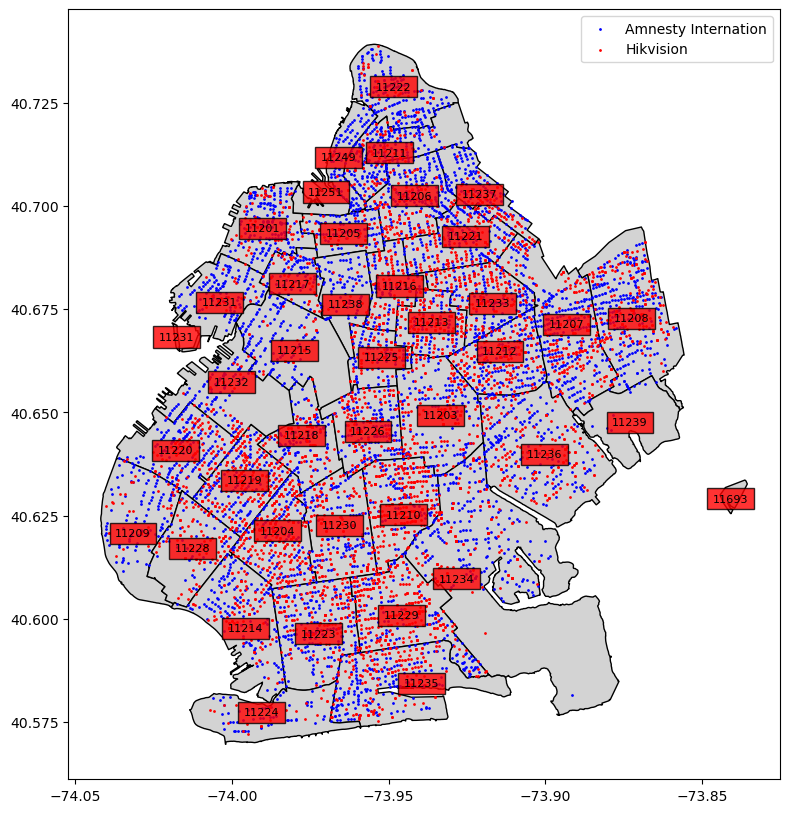

In [63]:
fig, ax = plt.subplots(figsize = (10,10))
bkzips.plot(ax = ax, color = 'lightgrey',edgecolor = 'black')
am_int.plot(ax = ax, color = 'b', markersize = 1, label = 'Amnesty Internation', legend = True)
hik.plot(ax = ax, color = 'r', markersize = 1, label = 'Hikvision', legend = True)

for idx, row in bkzips.iterrows():
    plt.text(x = row['coords'][0],y = row['coords'][1], s = row['ZIPCODE'],
             ha='center',va='center', color='black', fontsize = 8,bbox={'facecolor': 'red', 'alpha': 0.8})

ax.legend()

In [70]:
## create buffer zone around camera point locations
#add 120m around each shape
am_int = am_int.to_crs('EPSG:32118') # Use an appropriate projected system for your area
am_int['buffer_distance'] = 120 # in meters
buffered_gdf = pd.DataFrame()

for index, row in am_int.iterrows():
    polygon = row.geometry
    buffer_distance = row.buffer_distance
    buffered_polygon = polygon.buffer(buffer_distance, cap_style=1)
    buffered_gdf = buffered_gdf.append({'geometry': buffered_polygon}, ignore_index=True)
    
am_int_buff = gpd.GeoDataFrame(buffered_gdf,crs = am_int.crs)
am_int_buff = am_int_buff.to_crs('EPSG:4326') # Use an appropriate projected system for your area

In [91]:
am_int_buff_full = pd.merge(am_int.drop(columns=['geometry']),am_int_buff, left_index=True, right_index=True)
am_int_buff_full = gpd.GeoDataFrame(am_int_buff_full,geometry = 'geometry', crs = 'EPSG:4326')
am_int_buff_full.head()

,PanoramaId,n_cameras_,attached_s,attached_b,attached_u,type_dome_,type_bulle,type_unkno,n_camera_1,attached_1,...,type_unk_1,Lat,Long,geometry_p,BoroName,URL,ImageDate,buffer_distance,Coverage,geometry
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,120,Multiple Cameras,"POLYGON ((-73.96423 40.70615, -73.96424 40.706..."
7,-3_J1noE14rnXJQAOutg0g,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.629372,-73.972852,POINT (-73.972852 40.629372),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,120,Multiple Cameras,"POLYGON ((-73.93833 40.57824, -73.93834 40.578..."
10,-4FkkIbALjSxxgzxg-ssNg,1,0,0,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.706149,-73.965655,POINT (-73.9656547 40.7061494),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,120,Single Camera,"POLYGON ((-73.94401 40.65900, -73.94402 40.658..."
11,-4VW6uRzAgbhI_gYKrTxDQ,7,0,7,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,40.672012,-73.903590,POINT (-73.90359040904946 40.67201210342986),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-07,120,Multiple Cameras,"POLYGON ((-73.92101 40.59024, -73.92102 40.590..."
15,-694MYTbjy9EXcMHPlP6lw,1,0,1,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.675751,-73.959759,POINT (-73.95975884133387 40.67575133866482),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,120,Single Camera,"POLYGON ((-73.92927 40.69151, -73.92927 40.691..."


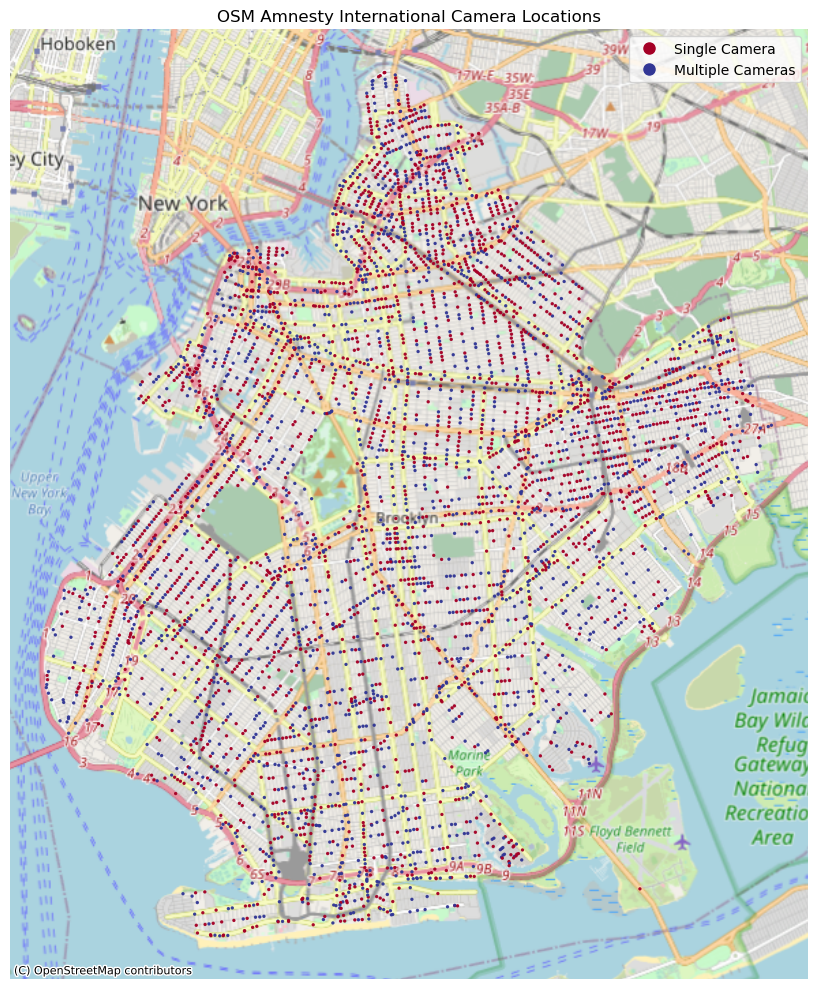

In [95]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Single Camera', 'B': 'Multiple Cameras'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
am_int.plot(column='Coverage', alpha=0.9, markersize=2, cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add a title to the plot
ax.set_title('Coverage Map')

# add the basemap using contextily
ctx.add_basemap(ax, crs=am_int.crs.to_string(),source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.tight_layout()
plt.title('OSM Amnesty International Camera Locations')
plt.savefig('../Outputs/OSM_AmnInternation_BK_CameraLocs.png')


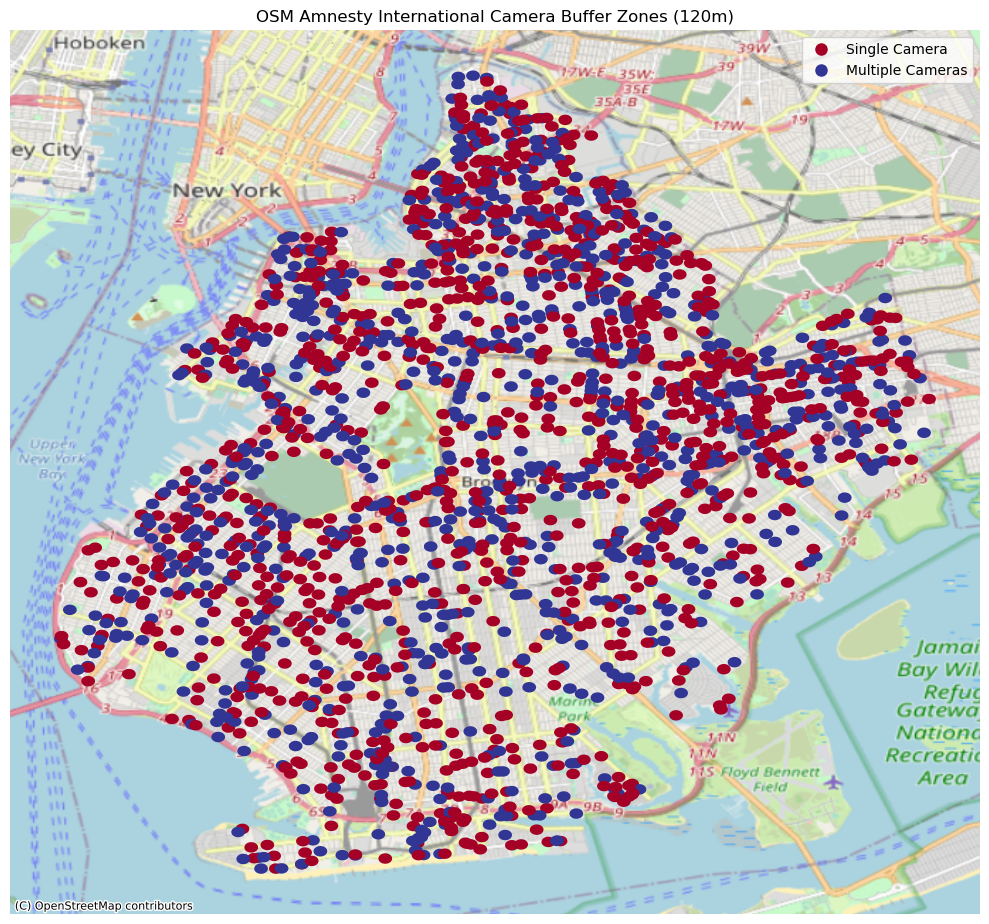

In [94]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Single Camera', 'B': 'Multiple Cameras'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
am_int_buff_full.plot(column='Coverage', cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add the basemap using contextily
ctx.add_basemap(ax, crs=am_int_buff_full.crs.to_string(),source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.tight_layout()
plt.title('OSM Amnesty International Camera Buffer Zones (120m)')
plt.savefig('../Outputs/OSM_AmnInternation_BK_CameraBuffer_120m.png')